In [1]:
import xarray as xr

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt


fileName = './yearly_tang.nc'
ds = xr.open_dataset(fileName)
print(ds)


<xarray.Dataset>
Dimensions:    (ncl0: 1, ncl1: 1, ncl2: 1, ncl3: 1, ncl4: 23837, ncl5: 23837)
Dimensions without coordinates: ncl0, ncl1, ncl2, ncl3, ncl4, ncl5
Data variables:
    startYear  (ncl0) int32 ...
    endYear    (ncl1) int32 ...
    latS       (ncl2) float32 ...
    latN       (ncl3) float32 ...
    accel      (ncl4) float64 ...
    years      (ncl5) float64 ...


<xarray.DataArray 'accel' (ncl4: 5)>
array([55.872319, 47.906964, 27.87704 ,  8.496313, -4.878097])
Dimensions without coordinates: ncl4
<xarray.DataArray 'years' (ncl5: 5)>
array([39284.   , 39284.125, 39284.25 , 39284.375, 39284.5  ])
Dimensions without coordinates: ncl5


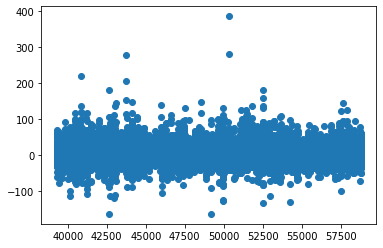

In [2]:
accel = ds.accel
years = ds.years

print(accel.head())
print(years.head())


plt.scatter(years,accel)



In [3]:
#data = np.vstack((years,accel)).T
#print(data)

df = pd.DataFrame({'years':years, 'accel':accel})
print(df)


           years      accel
0      39284.000  55.872319
1      39284.125  47.906964
2      39284.250  27.877040
3      39284.375   8.496313
4      39284.500  -4.878097
...          ...        ...
23832  58811.375  24.959386
23833  58811.500  34.897105
23834  58811.625  19.167725
23835  58811.750   2.846535
23836  58811.875   7.800952

[23837 rows x 2 columns]


In [4]:
mod = smf.quantreg('accel ~ years', df)
res = mod.fit(q=.5)
print(res.summary())


                         QuantReg Regression Results                          
Dep. Variable:                  accel   Pseudo R-squared:            0.0009452
Model:                       QuantReg   Bandwidth:                       2.188
Method:                 Least Squares   Sparsity:                        26.44
Date:                Wed, 11 Nov 2020   No. Observations:                23837
Time:                        09:20:16   Df Residuals:                    23835
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.6338      0.718     -5.059      0.000      -5.042      -2.226
years          0.0001   1.45e-05      7.140      0.000    7.49e-05       0.000

The condition number is large, 4.17e+05. This might indicate that there are
strong multicollinearity or other numerical problems.


In [5]:
quantiles = np.arange(.05,.95, .05)
def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params['Intercept'], res.params['years']] + \
            res.conf_int().loc['years'].tolist()

models = [fit_model(x1) for x1 in quantiles]
models = pd.DataFrame(models, columns=['q', 'a', 'b', 'lb', 'ub'])


ols = smf.ols('accel ~ years', df).fit()
ols_ci = ols.conf_int().loc['years'].tolist()
ols = dict(a = ols.params['Intercept'],
           b = ols.params['years'],
           lb = ols_ci[0],
           ub = ols_ci[1])

#print(models)
#print(ols)




print(models)



       q          a             b        lb        ub
0   0.05 -34.105329  1.781037e-04  0.000067  0.000290
1   0.10 -19.481096  6.038455e-05 -0.000018  0.000138
2   0.15 -12.630165  1.326544e-05 -0.000046  0.000073
3   0.20  -8.270111 -8.401929e-06 -0.000058  0.000041
4   0.25  -6.352955  2.904541e-06 -0.000035  0.000041
5   0.30  -5.417475  2.319437e-05 -0.000015  0.000062
6   0.35  -4.346168  4.101916e-05  0.000004  0.000078
7   0.40  -2.638926  4.134481e-05  0.000016  0.000066
8   0.45  -1.540557  3.490787e-05  0.000011  0.000059
9   0.50  -3.633792  1.032317e-04  0.000075  0.000132
10  0.55  -2.537398  1.142885e-04  0.000079  0.000149
11  0.60  -0.700473  1.098609e-04  0.000074  0.000146
12  0.65   1.127646  1.091276e-04  0.000071  0.000147
13  0.70   2.292377  1.264866e-04  0.000083  0.000170
14  0.75   5.012106  1.232599e-04  0.000071  0.000176
15  0.80   9.113898  1.039894e-04  0.000046  0.000162
16  0.85  15.158292  7.022127e-05 -0.000004  0.000144
17  0.90  24.679862 -6.69012

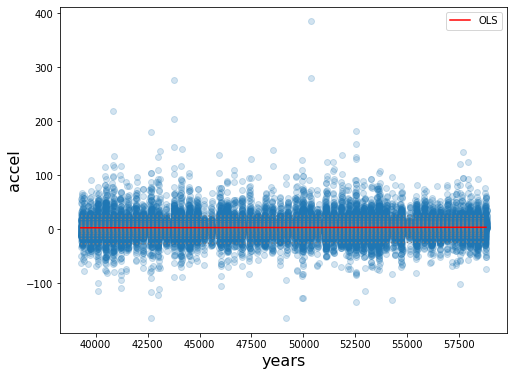

In [6]:
x = np.arange(df.years.min(), df.years.max(), 50)
get_y = lambda a, b: a + b * x

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle='dotted', color='grey')

y = get_y(ols['a'], ols['b'])

ax.plot(x, y, color='red', label='OLS')
ax.scatter(df.years, df.accel, alpha=.2)
#ax.set_xlim((240, 3000))
#ax.set_ylim((240, 2000))
legend = ax.legend()
ax.set_xlabel('years', fontsize=16)
ax.set_ylabel('accel', fontsize=16);

In [ ]:
n = models.shape[0]
p1 = plt.plot(models.q, models.b, color='black', label='Quantile Reg.')
p2 = plt.plot(models.q, models.ub, linestyle='dotted', color='black')
p3 = plt.plot(models.q, models.lb, linestyle='dotted', color='black')
p4 = plt.plot(models.q, [ols['b']] * n, color='red', label='OLS')
p5 = plt.plot(models.q, [ols['lb']] * n, linestyle='dotted', color='red')
p6 = plt.plot(models.q, [ols['ub']] * n, linestyle='dotted', color='red')
plt.ylabel(r'$\beta_{income}$')
plt.xlabel('Quantiles of the conditional food expenditure distribution')
plt.legend()
plt.show()